<a href="https://colab.research.google.com/github/Bhar8at/Mini-Projects/blob/main/Flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

In [ ]:
import numpy as np
Class_Names = [item.numpy().decode("utf-8") for item in tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
Class_Names = [item for item in Class_Names if item.find(".") == -1]
Class_Names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:

def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, reshape_dims)


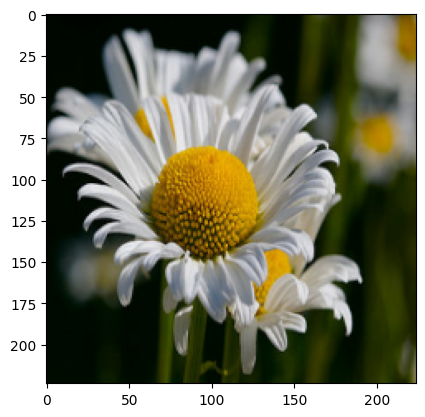

In [ ]:
import matplotlib.pyplot as plt

# Displaying an Image
def show_image(filename):
  img = read_and_decode(filename, [224,224])
  plt.imshow(img.numpy())
  plt.show()

show_image(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

In [ ]:
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")


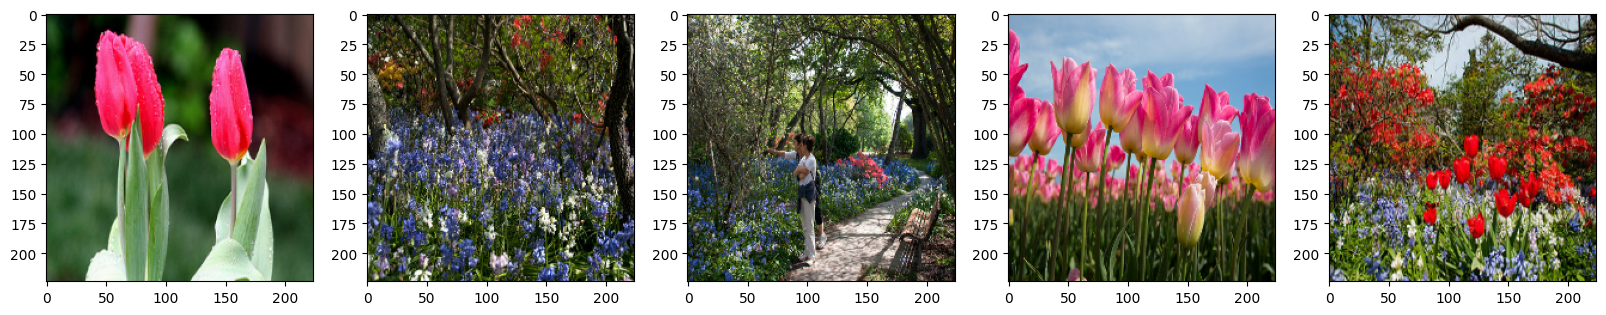

In [ ]:
f , ax = plt.subplots(1,5, figsize = (20,20))
for idx , filename in enumerate(tulips[:5]):
  img = read_and_decode(filename, [224,224])
  ax[idx].imshow(img.numpy())


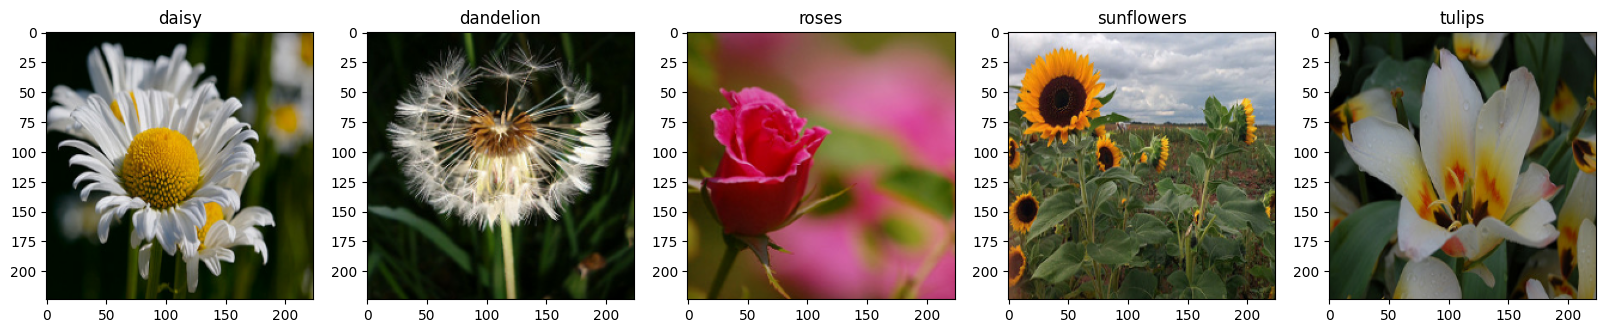

In [ ]:
f, ax = plt.subplots(1,5, figsize = (20,20))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [224,224])
  ax[idx].imshow(img)
  ax[idx].set_title(filename.split("/")[-2])

In [ ]:
def parse_csvline(csv_row):
  record_defaults = ['path', 'flower']
  filename, label = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [224,224])
  return img, label

dataset = (tf.data.TextLineDataset('gs://cloud-ml-data/img/flower_photos/train_set.csv').map(parse_csvline))


In [ ]:
for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis = [0,1])
  print(label, avg)


tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224,224,3)),
    tf.keras.layers.Dense(len(Class_Names))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
print(dataset.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [ ]:
for img, label in dataset.take(1):
  pred = model.predict(tf.reshape(img, [1,224,224,3]))
  pred_label_index = tf.math.argmax(pred[0]).numpy()
  pred_label = Class_Names[pred_label_index]
  print(pred_label, "==", label.numpy().decode("utf-8"), "?")
  print(pred[0][pred_label_index])
  print(pred[0])
  print("The Probabilities are : ",tf.math.softmax(pred[0]).numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
tulips == daisy ?
-0.14198965
[-0.18537757 -0.5543399  -0.6099096  -0.3219726  -0.14198965]
The Probabilities are :  [0.23462094 0.162229   0.15345989 0.20466535 0.24502474]


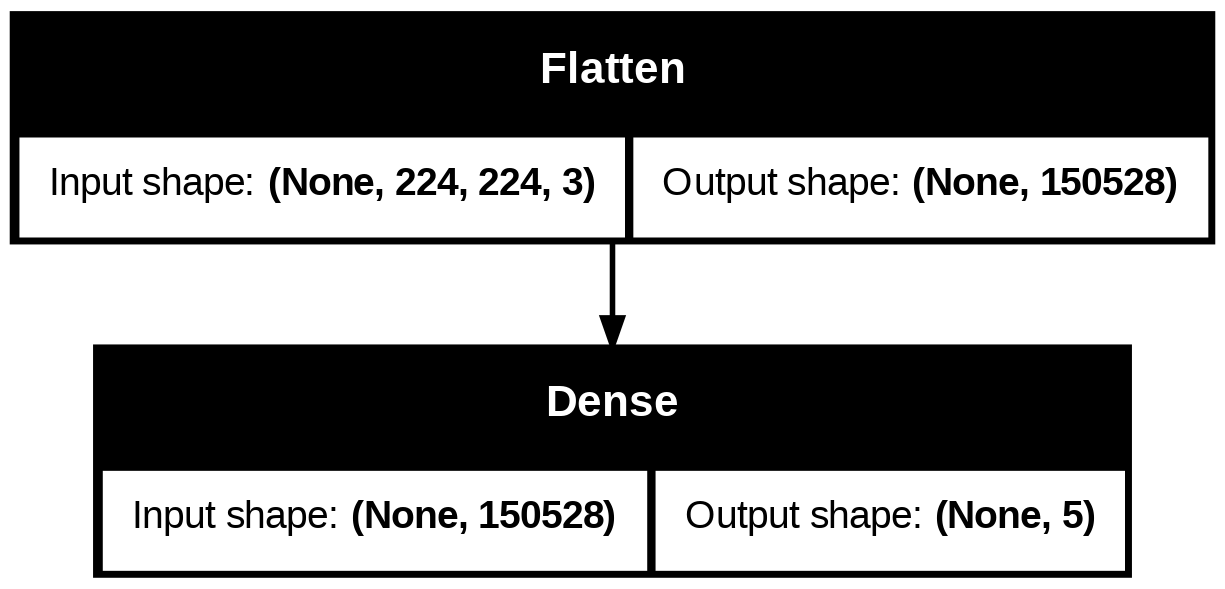

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)